# Building Regulatory Networks

Here we will build a modeling framework for regulatory networks with Lotka-Volterra semantics using Catlab.jl

In [1]:
using RegNets, RegNets.ASKEMRegNets
using Catlab
using JSON, HTTP, OrdinaryDiffEq, Plots

## Define the schema

### Graph Schema

Catlab provides a basic Graph schema out of the box

```julia
@present SchGraph(FreeSchema) begin
  V::Ob
  E::Ob
  src::Hom(E,V)
  tgt::Hom(E,V)
end
```

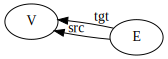

In [2]:
to_graphviz(SchGraph, edge_attrs=Dict(:len=>"1.5"))

### Basic Signed Graph Schema

The basic structure of a regulatory network can be represented by a signed graph. We simply want to add signs to each edge

```julia
@present SchSignedGraph <: SchGraph begin
  Sign::AttrType
  sign::Attr(E,Sign)
end
```

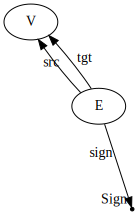

In [3]:
to_graphviz(SchSignedGraph, edge_attrs=Dict(:len=>"1.5"))

### Basic Signed Graph Schema with Rates

We also may want to keep track of rates of these interactions as well. Implicit rates on each vertice as well as rates on each edge.

```julia
@present SchRateSignedGraph <: SchSignedGraph begin
  A::AttrType
  vrate::Attr(V,A)
  erate::Attr(E,A)
end
```

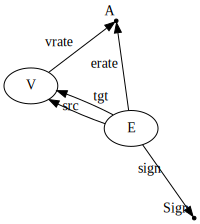

In [4]:
to_graphviz(SchRateSignedGraph, edge_attrs=Dict(:len=>"1.5"))

### ASKEM RegNet Schema

For our regulatory network models in ASKEM we also want to have labels on our edges and vertices as well as capture the initial concentrations along with this. We can easily extend our schema with these added attributes:

```julia
@present SchASKEMRegNet <: SchRateSignedGraph begin
 C::AttrType
 Name::AttrType
 initial::Attr(V,C)
 vname::Attr(V,Name)
 ename::Attr(E,Name)
end
```

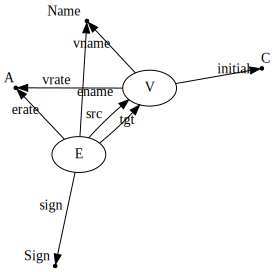

In [5]:
to_graphviz(SchASKEMRegNet, edge_attrs=Dict(:len=>"1.5"))

## Load the model

ASKEM's model representation repository defines a common structure for us to share models, we can use a simple JSON parser to load that into our new schema.

```julia
function parse_askem_model(input::AbstractDict)
  regnet = ASKEMRegNet()
  param_vals = Dict(p["id"]=>p["value"] for p in input["model"]["parameters"])
  resolve_val(x) = typeof(x) == String ? param_vals[x] : x

  vertice_idxs = Dict(vertice["id"]=> add_part!(regnet, :V;
    vname=Symbol(vertice["id"]),
    vrate = 0
    if haskey(vertice, "rate_constant")
      vrate = (vertice["sign"] ? 1 : -1) * resolve_val(vertice["rate_constant"])
    end
    initial=haskey(vertice, "initial") ? resolve_val(vertice["initial"]) : 0
  ) for vertice in input["model"]["vertices"])

  for edge in input["model"]["edges"]
    rate = 0
    if haskey(edge, "properties") && haskey(edge["properties"], "rate_constant")
      rate = resolve_val(edge["properties"]["rate_constant"])
      rate >= 0 || error("Edge rates must be strictly positive")
    end
    add_part!(regnet, :E; src=vertice_idxs[edge["source"]],
                          tgt=vertice_idxs[edge["target"]],
                          sign=edge["sign"],
                          ename=Symbol(edge["id"]),
                          erate=rate)
  end

  regnet
end
```

In [6]:
lotka_volterra = HTTP.get(
  "https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/main/regnet/examples/lotka_volterra.json"
).body |> String |> parse_askem_model

ASKEMRegNet with elements V = 1:2, E = 1:2, Sign = 1:0, A = 1:0, C = 1:0, Name = 1:0
┌───┬───────┬─────────┬───────┐
│ V │ vrate │ initial │ vname │
├───┼───────┼─────────┼───────┤
│ 1 │ 0.667 │     2.0 │     R │
│ 2 │  -1.0 │     1.0 │     W │
└───┴───────┴─────────┴───────┘
┌───┬─────┬─────┬───────┬───────┬───────────────────┐
│ E │ src │ tgt │  sign │ erate │             ename │
├───┼─────┼─────┼───────┼───────┼───────────────────┤
│ 1 │   2 │   1 │ false │ 1.333 │  wolf_eats_rabbit │
│ 2 │   1 │   2 │  true │   1.0 │ rabbit_feeds_wolf │
└───┴─────┴─────┴───────┴───────┴───────────────────┘

### Visualize the model

Catlab provides methods which can be overloaded with our new type to get modeling framework specific visualizations.

```julia
function Catlab.Graphics.to_graphviz_property_graph(sg::AbstractSignedGraph; kw...)
  get_attr_str(attr, i) = String(has_subpart(sg, attr) ? subpart(sg, i, attr) : Symbol(i))
  # make a new property graph
  pg = PropertyGraph{Any}(;kw...)
  # add vertices with labels for the visualization
  map(parts(sg, :V)) do v
    add_vertex!(pg, label=get_attr_str(:vname, v))
  end
  # add edges with labels and change the arrowhead
  # based on the sign of the edge for the visualization
  map(parts(sg, :E)) do e
    add_edge!(pg,
      sg[e, :src],
      sg[e, :tgt],
      label=get_attr_str(:ename, e),
      arrowhead=(sg[e,:sign] ? "normal" : "tee")
    )
  end
  pg
end
```

Then we can simply call `to_graphviz` and see our model:

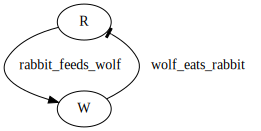

In [7]:
to_graphviz(lotka_volterra)

## Simulate the model

Next we want to have a method for calculating the dynamics from the model.

We can simply encode the Lotka-Volterra dynamics as a vectorfield function:

```julia
function vectorfield(sg::AbstractSignedGraph)
  (u, p, t) -> [
    p[:vrate][i]*u[i] + sum(
        (sg[e,:sign] ? 1 : -1)*p[:erate][e]*u[i]u[sg[e, :src]]
      for e in incident(sg, i, :tgt); init=0.0)
    for i in 1:nv(sg)
  ]
end
```

And we can use that to pass into an `ODEProblem` using DifferentialEquations.jl

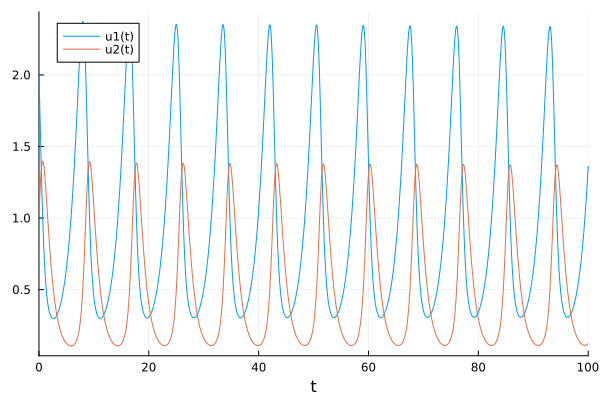

In [8]:
ODEProblem(
  vectorfield(lotka_volterra), # generate the vectorfield
  lotka_volterra[:initial],    # get the initial concentrations
  (0.0, 100.0),                # set the time period
  lotka_volterra,              # pass in model which contains the rate parameters
  alg=Tsit5()
) |> solve |> plot

## Autogenerated JSON Serialization

Catlab provides automatic serialization to JSON with these types both the models that fit within a given schema as well as the schema itself.

### Serialize the model

In [9]:
JSON.print(generate_json_acset(lotka_volterra), 2)

{
  "V": [
    {
      "_id": 1,
      "vrate": 0.667,
      "initial": 2.0,
      "vname": "R"
    },
    {
      "_id": 2,
      "vrate": -1.0,
      "initial": 1.0,
      "vname": "W"
    }
  ],
  "E": [
    {
      "_id": 1,
      "src": 2,
      "tgt": 1,
      "sign": false,
      "erate": 1.333,
      "ename": "wolf_eats_rabbit"
    },
    {
      "_id": 2,
      "src": 1,
      "tgt": 2,
      "sign": true,
      "erate": 1.0,
      "ename": "rabbit_feeds_wolf"
    }
  ],
  "Sign": [],
  "A": [],
  "C": [],
  "Name": []
}


### Serialize the ACSet schema

In [10]:
JSON.print(generate_json_acset_schema(SchASKEMRegNet), 2)

{
  "version": {
    "ACSets": "0.0.0",
    "ACSetSchema": "0.0.1"
  },
  "Ob": [
    {
      "name": "V"
    },
    {
      "name": "E"
    }
  ],
  "Hom": [
    {
      "name": "src",
      "codom": "V",
      "dom": "E"
    },
    {
      "name": "tgt",
      "codom": "V",
      "dom": "E"
    }
  ],
  "AttrType": [
    {
      "name": "Sign"
    },
    {
      "name": "A"
    },
    {
      "name": "C"
    },
    {
      "name": "Name"
    }
  ],
  "Attr": [
    {
      "name": "sign",
      "codom": "Sign",
      "dom": "E"
    },
    {
      "name": "vrate",
      "codom": "A",
      "dom": "V"
    },
    {
      "name": "erate",
      "codom": "A",
      "dom": "E"
    },
    {
      "name": "initial",
      "codom": "C",
      "dom": "V"
    },
    {
      "name": "vname",
      "codom": "Name",
      "dom": "V"
    },
    {
      "name": "ename",
      "codom": "Name",
      "dom": "E"
    }
  ]
}
